In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [ ]:
import numpy as np

import attr
import ujson
import random
import torch

from itertools import islice
from tqdm import tqdm_notebook
from glob import glob
from collections import Counter

from gensim.models import KeyedVectors

from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import functional as F

In [5]:
vectors = KeyedVectors.load_word2vec_format(
    '../data/vectors/GoogleNews-vectors-negative300.bin.gz',
    binary=True,
)

In [6]:
class Corpus:
    
    def __init__(self, pattern, skim=None):
        self.pattern = pattern
        self.skim = skim
        
    def lines(self):
        for path in glob(self.pattern):
            with open(path) as fh:
                for line in fh:
                    yield line.strip()

    def abstracts(self):
        lines = self.lines()
        if self.skim:
            lines = islice(lines, self.skim)
        for line in tqdm_notebook(lines, total=self.skim):
            raw = ujson.loads(line)
            yield Abstract.from_raw(raw)
            
    def xy(self):
        for abstract in self.abstracts():
            yield from abstract.xy()

In [7]:
@attr.s
class Abstract:
    
    sentences = attr.ib()
    
    @classmethod
    def from_raw(cls, raw):
        return cls([Sentence(s['token']) for s in raw['sentences']])
            
    def xy(self):
        for i, sent in enumerate(self.sentences):
            try:
                x = sent.tensor()
                y = i / (len(self.sentences)-1)
                y = torch.FloatTensor([y])
                yield x, y
            except RuntimeError as e:
                pass

In [8]:
@attr.s
class Sentence:
    
    tokens = attr.ib()
    
    def tensor(self, dim=300, pad=50):
        x = [vectors[t] for t in self.tokens if t in vectors]
        x += [np.zeros(dim)] * pad
        x = x[:pad]
        x = np.array(x)
        x = torch.from_numpy(x)
        x = x.float()
        return x

In [82]:
class Model(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.hidden2y = nn.Linear(hidden_dim, 1)
        
    def init_hidden(self):
        self.hidden = (
            Variable(torch.zeros(1, 1, self.hidden_dim)),
            Variable(torch.zeros(1, 1, self.hidden_dim)),
        )
        
    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x, self.hidden)
        y = self.hidden2y(hn)
        return y

In [83]:
train = Corpus('../data/train.json/*.json', 10000)

In [84]:
train_xy = list(train.xy())

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

In [92]:
loader = DataLoader(train_xy, 64)

In [99]:
torch.manual_seed(1)

In [100]:
embed_dim = train_xy[0][0].shape[1]

In [101]:
model = Model(embed_dim, 300)

In [102]:
criterion = nn.MSELoss()

In [103]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [104]:
train_loss = []
for epoch in range(10):
    
    print(f'Epoch {epoch}')
    
    epoch_loss = 0
    for x, y in tqdm_notebook(loader):

        x = Variable(x)
        y = Variable(y)

        model.zero_grad()
        model.init_hidden()

        y_pred = model(x)

        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()
        
        epoch_loss += loss.data[0]
        
    epoch_loss /= len(loader)
    train_loss.append(epoch_loss)
    print(epoch_loss)

Epoch 0


HBox(children=(IntProgress(value=0, max=840), HTML(value='')))


0.13090669236012867
Epoch 1


HBox(children=(IntProgress(value=0, max=840), HTML(value='')))


0.10813104567960614
Epoch 2


HBox(children=(IntProgress(value=0, max=840), HTML(value='')))


0.09805212249713284
Epoch 3


HBox(children=(IntProgress(value=0, max=840), HTML(value='')))


0.09488736633654861
Epoch 4


HBox(children=(IntProgress(value=0, max=840), HTML(value='')))


0.09224788862324897
Epoch 5


HBox(children=(IntProgress(value=0, max=840), HTML(value='')))


0.09018124857296546
Epoch 6


HBox(children=(IntProgress(value=0, max=840), HTML(value='')))


0.08843216832638497
Epoch 7


HBox(children=(IntProgress(value=0, max=840), HTML(value='')))


0.08683009834161827
Epoch 8


HBox(children=(IntProgress(value=0, max=840), HTML(value='')))


0.08532775712332555
Epoch 9


HBox(children=(IntProgress(value=0, max=840), HTML(value='')))


0.08390700684062072


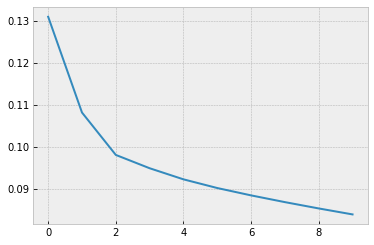

In [105]:
plt.plot(train_loss)

In [106]:
dev = Corpus('../data/dev.json/*.json', 1000)

In [107]:
correct = Counter()
total = Counter()

for ab in dev.abstracts():
    
    x, _ = zip(*ab.xy())

    x = torch.stack(x)
    x = Variable(x)
    
    model.init_hidden()

    y = model(x)
    
    y = np.array(y.data[0].tolist())[:,0]
    order = list(y.argsort().argsort())
    
    if sorted(order) == order:
        correct[len(order)] += 1
        
    total[len(order)] += 1

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [108]:
for slen in sorted(correct.keys()):
    print(slen, correct[slen] / total[slen])

2 0.8865979381443299
3 0.5298013245033113
4 0.27624309392265195
5 0.0903954802259887
6 0.03418803418803419
7 0.01
8 0.016666666666666666


In [109]:
sum(correct.values()) / sum(total.values())

0.238

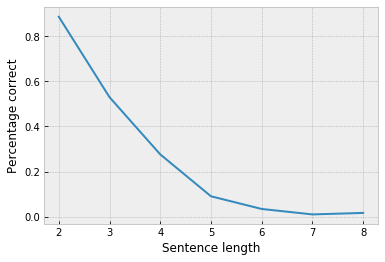

In [110]:
x = sorted(correct.keys())
y = [correct[slen] / total[slen] for slen in x]

plt.xlabel('Sentence length')
plt.ylabel('Percentage correct')
plt.plot(x, y)